# **TON CRM Analytics - Data Analysis**

**Impotando bibliotecas necessárias**

In [1]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Biliotecas utilitárias
import pylab as pl
from datetime import datetime
from dateutil import relativedelta

# Configuração do Notebook
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

**Importando dataset limpo para o Jupyter Notebook**

In [2]:
# Carregando as bases limpas para o Notebook
cases = pd.read_csv('data/cases_cleaned.csv', parse_dates = ['date_ref'])
creds = pd.read_csv('data/creds_cleaned.csv', parse_dates = ['cred_date'])

In [3]:
# Recuperando dados de waiting_timedelta para tipo timedetal
cases['waiting_timedelta'] = pd.to_timedelta(cases['waiting_timedelta'])

## Efeito da nova funcionalidade nos chamados

In [4]:
# Criando valor de refência para futuro agregamento de informação
cases['calls'] = 1
# cases.head(3)

In [5]:
# Verificando dadas nos limites superior e inferior do dataset
print('Corte de data do dataset              :', cases['date_ref'].max())
print('Data da implementação da nova feature : ', pd.to_datetime('2020-08-01'))

Corte de data do dataset              : 2020-10-29 00:00:00
Data da implementação da nova feature :  2020-08-01 00:00:00


In [6]:
cases_agg = cases.groupby('date_ref')[['account_id']].count()
cases_agg.rename(columns = {'account_id': 'n_cases'}, inplace = True)
cases_agg.head()

,n_cases
date_ref,
2020-02-23,1
2020-02-25,1
2020-02-26,22
2020-02-27,31
2020-02-28,27


**Separando dataset antes e depois da implementação da nova feature**

Após criar um dataset com dados agregadaos para a análise requerida, com base nos dados disponíveis para esta análise, para determinar se a feature implementada no começo de agosto ajudou a diminuir a quantidade de ligações para a CR é necessário separar o dataset agregado em dois: um ates da data de implementação da feature, 01 de agosto de 2020, e outro após essa data. Assim, é possível fazer uma comparação entre as médias e demais análises estatíticas.

Antes, entretanto, verificamos a quantidade de dados que haverá em cada um desses datasets após a divisão:

In [7]:
# Guardando data da implementação da nova feature em uma nova variável: 'shift_date'
shift_date = pd.to_datetime('2020-08-01')

In [8]:
# Verificando o shape dos datasets
cases_agg[cases_agg.index < shift_date].shape, cases_agg[cases_agg.index >= shift_date].shape

((155, 1), (90, 1))

Como suspeitado, os dados estão desbalanceados. Vamos verificar a distribuição dos dados em cada um deles e ver o quanto esse desbalance poderia afetar nossa análise.

In [9]:
# Verificando média de chamados nos períodos antes e depois da nova feature
mean_n_cases_before = cases_agg[cases_agg.index < shift_date]['n_cases'].mean()
print('Média de chamados antes do shift_date: ', 
      round(mean_n_cases_before, 2))

mean_n_cases_after = cases_agg[cases_agg.index >= shift_date]['n_cases'].mean()
print('Média de chamados após o shift_date  : ', 
      round(mean_n_cases_after, 2))

Média de chamados antes do shift_date:  196.21
Média de chamados após o shift_date  :  523.08


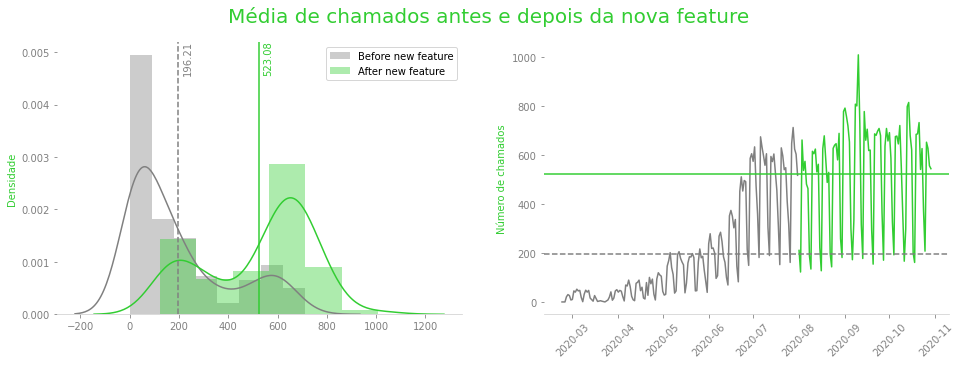

In [10]:
# Plotando um histograma para visualizar a diferença
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
fig.suptitle('Média de chamados antes e depois da nova feature', fontsize = 20, color = 'limegreen')

sns.distplot(cases_agg[cases_agg.index < shift_date], color = 'gray', label = 'Before new feature', ax = ax[0]) 
sns.distplot(cases_agg[cases_agg.index >= shift_date], color = 'limegreen', label = 'After new feature', ax = ax[0])
ax[0].axvline(mean_n_cases_before, color = 'gray', linestyle = '--')
ax[0].axvline(mean_n_cases_after, color = 'limegreen', linestyle = '-')
ax[0].set(ylabel = "Densidade")
ax[0].text(x = mean_n_cases_before + 20, y = 0.0046, s = round(mean_n_cases_before, 2), rotation = 90, color = 'gray')
ax[0].text(x = mean_n_cases_after + 20, y = 0.0046, s = round(mean_n_cases_after, 2), rotation = 90, color = 'limegreen')
ax[0].legend()

ax[0].spines['bottom'].set_color('lightgray')
ax[0].xaxis.label.set_color('gray')
ax[0].tick_params(axis='both', colors='gray')
ax[0].yaxis.label.set_color('limegreen')

plt.plot(cases_agg[cases_agg.index < shift_date]['n_cases'], color = 'gray', label = 'Before new feature')
plt.plot(cases_agg[cases_agg.index >= shift_date]['n_cases'], color = 'limegreen', label = 'After new feature')
plt.ylabel('Número de chamados')
ax[1].axhline(mean_n_cases_before, color = 'gray', linestyle = '--')
ax[1].axhline(mean_n_cases_after, color = 'limegreen', linestyle = '-')

ax[1].spines['bottom'].set_color('lightgray')
ax[1].xaxis.label.set_color('gray')
ax[1].tick_params(axis='both', colors='gray')
ax[1].yaxis.label.set_color("limegreen")

plt.xticks(rotation = 45)
# ax[1].legend()

sns.despine(top = True, left = True)
plt.show()

O gráfico com os dados desbalanceados incluem um período do business em que a quantidade de ligações para a CR era pequena. Isso faz com que as médias dos dois períodos seja muito discrepante, não sendo ideal para essa análise.

Vamos balanccear o dataset incluindo a mesma quantidade de dias antes e depois da implementação da nova feature.

In [11]:
# Estabelecendo data para balanceamento dos dados
first_date = shift_date - np.timedelta64(90, 'D') # 90 dias, incluindo a shift_date
first_date # 2020-05-03

Timestamp('2020-05-03 00:00:00')

In [12]:
# Balanceando os dados dos dois datasets selecionando a mesma quantidade de entradas para ambos
cases_before = cases_agg[(cases_agg.index >= first_date) & (cases_agg.index < shift_date)]
cases_after = cases_agg[cases_agg.index >= shift_date]

# Verificando shape após balanceamento
cases_before.shape, cases_after.shape

((90, 1), (90, 1))

Os dois datasets agora possuem a mesma quantidade de dias, o que viabiliza a nossa análise.
No entanto, o periodo antes da implementação da nova feature ainda contempla um período em que o business estava crescendo. O que novamente faz com que a análise seja injusta.

Para normalizar os dados, uma estratégia é analisar o cenário: quem são as pessoas que fazem as ligações para a central? Os clientes cadastrados na base. Mesmo que a maioria dos chamados seja feito por novos clientes, como investigaremos mais adiante, todos podem realizar ligações para a CR.

Uma maneira de normalizar esses dados portanto seria dividir a quantidade de chamados pelo total de clientes cadastrados na base em determinada data e então a comparação das médias seria mais justa.

**Normalizando a base de dados: chamados diários pelo total de clientes da base**

Para realizar esse cálculo, primeiro calculamos a soma acumulada de chamados:

In [13]:
# cases_agg_full = cases.groupby('date_ref').agg({'account_id': ['count'], 
#                                            'pesq_satisfacao': 'count',
#                                            'waiting_time': 'mean'})

In [14]:
# # Criando tabela com dados número de casos (chamados) agregados por data de credenciamento
# cases_agg = cases.groupby('date_ref')[['account_id']].count()

# # Renomenado coluna agregada para facilitar entendimento
# cases_agg = cases_agg.rename(columns = {'account_id': 'n_cases'})

# Criando coluna para soma acumulada de chamados (tamanho da base)
cases_agg['soma_acum_cases'] = cases_agg['n_cases'].cumsum()
cases_agg

,n_cases,soma_acum_cases
date_ref,,
2020-02-23,1,1
2020-02-25,1,2
2020-02-26,22,24
2020-02-27,31,55
2020-02-28,27,82
...,...,...
2020-10-25,208,75110
2020-10-26,652,75762
2020-10-27,627,76389


Como a tabela de cados agregados, como vimos anteriormente, contém dados desbalanceados (mais dias antes da implementação da feature, menos dias deposi). Precisamos novamente descartar os dados dados anteriores a 90 dias antes da implementação da feature (conforme informação previamente calculada e guardada na variável `first_date`).

In [15]:
# Selecionando périodo de corte para análise de relevância estatística na tabela Cases
cases_tomerge = cases_agg[cases_agg.index >= first_date]
cases_tomerge

,n_cases,soma_acum_cases
date_ref,,
2020-05-03,32,2634
2020-05-04,147,2781
2020-05-05,169,2950
2020-05-06,202,3152
2020-05-07,141,3293
...,...,...
2020-10-25,208,75110
2020-10-26,652,75762
2020-10-27,627,76389


A normalização dos dados exige que busquemos informações sobre a quantidade de clientes credenciados na base `creds`. Será preciso gazer um JOIN dessas duas tabelas, tendo como _index_ a data. Por essa razão o dataset criado assima leva o sufixo `_tomerge`. 

Agora, criamos um dataset agregado com as informações da tabela de credenciamentos, incluindo o número de credenciamentos diários e a soma acumulada de clientes credenciados:

In [16]:
# Criando tabela com dados número de casos (chamados) agregados por data de credenciamento
creds_agg = creds.groupby('cred_date').count()[['account_id']]

# Renomenado coluna agregada para facilitar entendimento
creds_agg = creds_agg.rename(columns = {'account_id': 'n_creds'})

# Criando coluna para soma acumulada de chamados (tamanho da base)
creds_agg['soma_acum_creds'] = creds_agg['n_creds'].cumsum()

creds_agg

,n_creds,soma_acum_creds
cred_date,,
2019-07-24,12,12
2019-07-25,15,27
2019-07-26,23,50
2019-07-27,9,59
2019-07-28,4,63
...,...,...
2020-10-26,11,31235
2020-10-27,85,31320
2020-10-28,53,31373


Novamente, também para esse dataset selecionamos apenas os dados de nosso interesse, descartando valores mais antigos que 90 dias:

In [17]:
# Selecionando périodo de corte para análise de relevância estatística na tabela Creds
creds_tomerge = creds_agg[creds_agg.index >= first_date]
creds_tomerge.head()

,n_creds,soma_acum_creds
cred_date,,
2020-05-03,21,3994
2020-05-04,68,4062
2020-05-05,161,4223
2020-05-06,131,4354
2020-05-07,123,4477


**Realizando JOIN entre as duas tabelas**

In [18]:
cred_cases = creds_tomerge.merge(cases_tomerge, how = 'inner', left_index = True, right_index = True)
cred_cases.head()
cred_cases.shape

(180, 4)

**Calculando número de chamados pelo total de clientes cadastrados na base diário, `calls_per_total_creds`**

In [19]:
cred_cases['calls_per_new_creds'] = round((cred_cases['n_cases'] / cred_cases['n_creds']), 2)
cred_cases['calls_per_total_creds'] = round((cred_cases['n_cases'] / cred_cases['soma_acum_creds']), 5)
cred_cases.head()

,n_creds,soma_acum_creds,n_cases,soma_acum_cases,calls_per_new_creds,calls_per_total_creds
2020-05-03,21,3994,32,2634,1.52,0.00801
2020-05-04,68,4062,147,2781,2.16,0.03619
2020-05-05,161,4223,169,2950,1.05,0.04002
2020-05-06,131,4354,202,3152,1.54,0.04639
2020-05-07,123,4477,141,3293,1.15,0.03149


In [20]:
# Separando tabela agregada entre período antes e depois da implementação da nova feature
cred_cases_before = cred_cases[cred_cases.index < shift_date]
cred_cases_after = cred_cases[cred_cases.index >= shift_date]

cred_cases_before.shape, cred_cases_after.shape

((90, 6), (90, 6))

In [21]:
# Checando se corte está correto
cred_cases_after.head(1) # Primeira data é 2020-08-01, portanto, correto!

,n_creds,soma_acum_creds,n_cases,soma_acum_cases,calls_per_new_creds,calls_per_total_creds
2020-08-01,128,17482,211,30623,1.65,0.01207


In [22]:
# Verificando média de chamados nos períodos antes e depois da nova feature
mean_cases_per_total_creds_before = cred_cases_before['calls_per_total_creds'].mean()
print('Média de chamados pelo tamanho da base de clientes credenciados antes do shift_date: ', 
      round(mean_cases_per_total_creds_before, 5))

mean_cases_per_total_creds_after = cred_cases_after['calls_per_total_creds'].mean()
print('Média de chamados pelo tamanho da base de clientes credenciados após o shift_date  : ', 
      round(mean_cases_per_total_creds_after, 5))

Média de chamados pelo tamanho da base de clientes credenciados antes do shift_date:  0.02959
Média de chamados pelo tamanho da base de clientes credenciados após o shift_date  :  0.02119


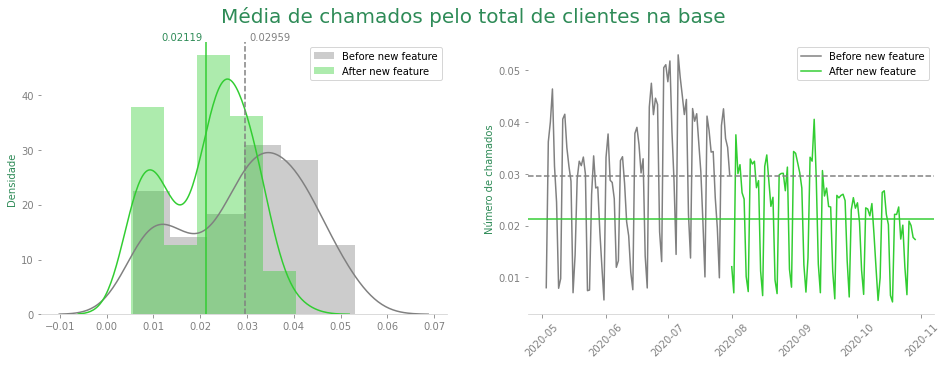

In [23]:
# Plotando um histograma para visualizar a diferença
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

plt.gcf()
fig.suptitle('Média de chamados pelo total de clientes na base', fontsize = 20, color = 'seagreen')

sns.distplot(cred_cases_before['calls_per_total_creds'], color = 'gray', label = 'Before new feature', ax = ax[0]) 
sns.distplot(cred_cases_after['calls_per_total_creds'], color = 'limegreen', label = 'After new feature', ax = ax[0])
ax[0].axvline(mean_cases_per_total_creds_before, color = 'gray', linestyle = '--')
ax[0].axvline(mean_cases_per_total_creds_after, color = 'limegreen', linestyle = '-')
ax[0].set(ylabel = "Densidade", xlabel = '')
ax[0].text(x = mean_cases_per_total_creds_before + 0.001, y = 50, s = round(mean_cases_per_total_creds_before, 5), rotation = 0, color = 'gray')
ax[0].text(x = mean_cases_per_total_creds_after - .0095, y = 50, s = round(mean_cases_per_total_creds_after, 5), rotation = 0, color = 'seagreen')
ax[0].legend()

ax[0].spines['bottom'].set_color('lightgray')
ax[0].xaxis.label.set_color('gray')
ax[0].tick_params(axis='both', colors='gray')
ax[0].yaxis.label.set_color("seagreen")

plt.plot(cred_cases_before['calls_per_total_creds'], color = 'gray', label = 'Before new feature')
plt.plot(cred_cases_after['calls_per_total_creds'], color = 'limegreen', label = 'After new feature')
plt.ylabel('Número de chamados')
ax[1].axhline(mean_cases_per_total_creds_before, color = 'gray', linestyle = '--')
ax[1].axhline(mean_cases_per_total_creds_after, color = 'limegreen', linestyle = '-')

ax[1].spines['bottom'].set_color('lightgray')
ax[1].xaxis.label.set_color('gray')
ax[1].tick_params(axis='both', colors='gray')
ax[1].yaxis.label.set_color("seagreen")

plt.xticks(rotation = 45)
ax[1].legend()

sns.despine(top = True, left = True)
plt.show()

**Calculando o desvio padrão das das distribuições**

In [24]:
std_cases_per_total_creds_before = cred_cases_before['calls_per_total_creds'].std(ddof = 0)
print('Desvio padrão de chamados pelo tamanho da base de clientes credenciados antes do shift_date:  ', 
      round(std_cases_per_total_creds_before, 4))

std_cases_per_total_creds_after = cred_cases_after['calls_per_total_creds'].std(ddof = 0)
print('Desvio padrão de chamados pelo tamanho da base de clientes credenciados depois do shift_date: ', 
      round(std_cases_per_total_creds_after, 4))

Desvio padrão de chamados pelo tamanho da base de clientes credenciados antes do shift_date:   0.0128
Desvio padrão de chamados pelo tamanho da base de clientes credenciados depois do shift_date:  0.0092


Observamos que, após a implementação da nova feature, houve uma diminuição na média de chamados pelo total de clientes cadastrados na base. No entanto, a ordem de grandeza entre a diferença de médias pode ser medida em milésimos e seus desvios padrões mostram que com que uma pequena variação nos dados, as médias podem ser ainda menos diferentes.

Para saber se essa diferença é estatísticamente significativa, é necessário conduzir um teste de hipótese. 

### Teste de hipotese para distribuições não paraméricas

Antes de mais nada, vamos estabelecer as hipóteses do nosso teste e setar um valor alpha:
  
<br>
<b><center><mark>H<sub>0</sub>: O número de chamados se manteve igual.</mark></center>
<br>
<center><mark>H<sub>a</sub>: O número de chamados diminuiu.</mark></center></b>

O valor **_alfa_** em nosso teste é o nível de risco que aceitamos ao decidir que um efeito existe, quando na verdade ele não existe. Um valor padrão para os testes de hipótese é alfa = 5%, no entanto, como nossa amostra é relativamente pequena, podemos assumir um valor de **10%**. 

Depois, precisamos estabelecer alguns pressupostos dos nossos dados.

1. Ditribuibção não paramétrica (não segue a distribuição normal, ou gaussiana);
2. As amostras são dependentes, uma vez que os indivíduos fazendo as ligações podem ser os mesmos, e, além disso, transformamos o número de ligações em uma taxa de ligações por tamanho da base.

O **Teste de Wilcoxon** atende à esses pressupostos.

**Aplicando Teste de Wilcoxon aos dados**

In [25]:
from scipy.stats import wilcoxon

statistic, p = wilcoxon(cred_cases_before['calls_per_total_creds'], # p é o p-valor
               cred_cases_after['calls_per_total_creds'], alternative = 'less') # Alternative = 'less' testa 
                                                                                # para casos que estamos avaliando a 
                                                                                # hipótese alternativa é menor, 
                                                                                # ou diminuiu.
            
alpha = 0.1 #
if p > alpha:
    print('Não há diferença entre as distribuições (Falha ao rejeitar H0); p-valor: ', p)
else:
    print('Há diferença entre as distribuições (Rejeita H0); p-valor: ', p)

Não há diferença entre as distribuições (Falha ao rejeitar H0); p-valor:  0.9999956294765974


In [26]:
# EXPLICAR MELHOR O CONCEITO DE P-VALOR E O RESULTADO

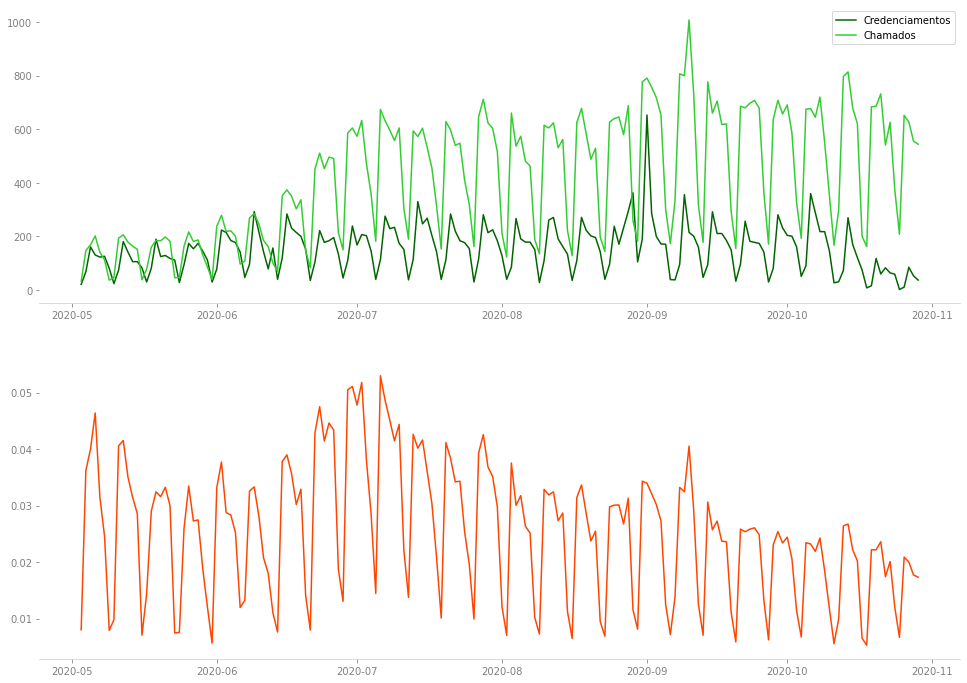

In [27]:
fig, ax = plt.subplots(2, 1, figsize = (16.5, 12))

ax[0].plot(cred_cases['n_creds'], label = 'Credenciamentos', color = 'darkgreen')
ax[0].plot(cred_cases['n_cases'], label = 'Chamados', color = 'limegreen')
ax[0].spines['bottom'].set_color('lightgray')
ax[0].legend(loc = 'best')

ax[0].spines['bottom'].set_color('lightgray')
ax[0].xaxis.label.set_color('gray')
ax[0].tick_params(axis='both', colors='gray')
ax[0].yaxis.label.set_color("seagreen")

# plt.plot(cred_cases['n_cases'] - cred_cases['n_creds'])

ax[1].plot(cred_cases['calls_per_total_creds'], color = 'orangered')
ax[1].spines['bottom'].set_color('lightgray')
ax[1].xaxis.label.set_color('gray')
ax[1].tick_params(axis='both', colors='gray')
# ax[1].yaxis.label.set_color("seagreen")

sns.despine(top = True, left = True)
plt.show()

In [28]:
# TALVEZ UMA MODELO TIME SERIES PARA VERIFICAR A TENDENCIA DE CREDENCIAMENTOS, CHAMADOS E CHAMADOS/CREDENCIAMENTOS

___

In [29]:
# Juntando dados (selecionados acima) da tabela cred à tabela cases
mcases = cases.merge(creds, on = 'account_id', how = 'left', suffixes = ('_cases', '_creds'))
mcases.head(3)

,account_id,date_ref,waiting_time,missed,pesq_satisfacao,assunto,waiting_timedelta,year_cases,month_cases,day_cases,weekday_cases,weekday_str_cases,node_1,node_2,node_3,calls,cred_date,ship_city,ship_state,max_machine,year_creds,month_creds,day_creds,weekday_creds,weekday_str_creds
0,0011L00002ZbpnlQAB,2020-02-23,19,False,Enviado,"['Produto', 'mPOS', 'Dúvidas mpos']",0 days 00:00:19,2020,2,23,6,Dom,Produto,mPOS,Dúvidas mpos,1,2019-10-28,Atibaia,SP,T1,2019,10,28,0,Seg
1,0011L00002dbBg5QAE,2020-02-25,15,False,Enviado,"['Aplicativo', 'Problema', '']",0 days 00:00:15,2020,2,25,1,Ter,Aplicativo,Problema,NaN,1,2020-02-12,Alexânia,GO,T3,2020,2,12,2,Qua
2,0011L00002WdgbcQAB,2020-02-26,15,False,Enviado,"['Aplicativo', 'Dúvidas funcionalidades App', ...",0 days 00:00:15,2020,2,26,2,Qua,Aplicativo,Dúvidas funcionalidades App,Redefinição de senha,1,2019-07-28,Indaiatuba,SP,NONE,2019,7,28,6,Dom


In [30]:
mcases['interval_cred_call'] = (mcases['date_ref'] - mcases['cred_date']).dt.days
mcases.head(3)

,account_id,date_ref,waiting_time,missed,pesq_satisfacao,assunto,waiting_timedelta,year_cases,month_cases,day_cases,weekday_cases,weekday_str_cases,node_1,node_2,node_3,calls,cred_date,ship_city,ship_state,max_machine,year_creds,month_creds,day_creds,weekday_creds,weekday_str_creds,interval_cred_call
0,0011L00002ZbpnlQAB,2020-02-23,19,False,Enviado,"['Produto', 'mPOS', 'Dúvidas mpos']",0 days 00:00:19,2020,2,23,6,Dom,Produto,mPOS,Dúvidas mpos,1,2019-10-28,Atibaia,SP,T1,2019,10,28,0,Seg,118
1,0011L00002dbBg5QAE,2020-02-25,15,False,Enviado,"['Aplicativo', 'Problema', '']",0 days 00:00:15,2020,2,25,1,Ter,Aplicativo,Problema,NaN,1,2020-02-12,Alexânia,GO,T3,2020,2,12,2,Qua,13
2,0011L00002WdgbcQAB,2020-02-26,15,False,Enviado,"['Aplicativo', 'Dúvidas funcionalidades App', ...",0 days 00:00:15,2020,2,26,2,Qua,Aplicativo,Dúvidas funcionalidades App,Redefinição de senha,1,2019-07-28,Indaiatuba,SP,NONE,2019,7,28,6,Dom,213


In [31]:
def n_call_timewindow(df, n_days = 100, plot = False):
    '''
    This function calculates the number of calls (cases) after n_days // 7 entrance in the cred database and returns a pd.DataFrame with columns being the weeks ahead of entrance.
    
    Parameters:
    
    ** n_days: 
    Number of days to be included in the analysis. Please observe that the output will be in weeks, therefore the number of days will be divided by 7, and remainders will be discarded.
    
    ** plot (default, False)
    If set to True, will plot a horizontal bar chat instead of showing a pd.DataFrame.\n
    ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    '''
    df = df.copy()
    
    week = n_days // 7
    for i in range(0, week + 1):
        if i == 0:
            df[f'Semana #{i + 1}'] = (df['interval_cred_call'] <= (i + 7)).astype(int)
#             print(f'interval_{i + 7}\nn_calls: ', df[f'interval_{i + 7}'].value_counts()[1], '\n================')
        else:
            df[f'Semana #{i + 1}'] = ((df['interval_cred_call'] > (i * 7)) & 
                                             (df['interval_cred_call'] <= ((i + 1) * 7))).astype(int)
#             print(f'interval_{(i + 1) + 7}\nn_calls: ', df[f'interval_{((i + 1) * 7)}'].value_counts()[1], '\n================')
    
    df = df.iloc[:, -(week + 1):-1] # INCLUIR COLUNA 'account_id'
    
    if plot == True:
        fig, ax = plt.subplots(1, figsize = (15, 5))
        fig.suptitle('Total de chamados realizados após Credenciamento\n(por semana, a partir da entrada na base)',
                     fontsize = 20, color = 'darkgreen')
        fig.tight_layout()
        df.sum().plot(kind = 'barh', alpha = .8, width = .8, color = 'limegreen', zorder = 2).invert_yaxis()
        ax.grid(b = True, axis = 'x', alpha = .2, zorder = 1)
        ax.tick_params(axis='both', colors='gray', labelsize = 14, labelcolor = 'dimgray')
        ax.spines['left'].set_color('lightgray')
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        return f'{fig}'

    return df

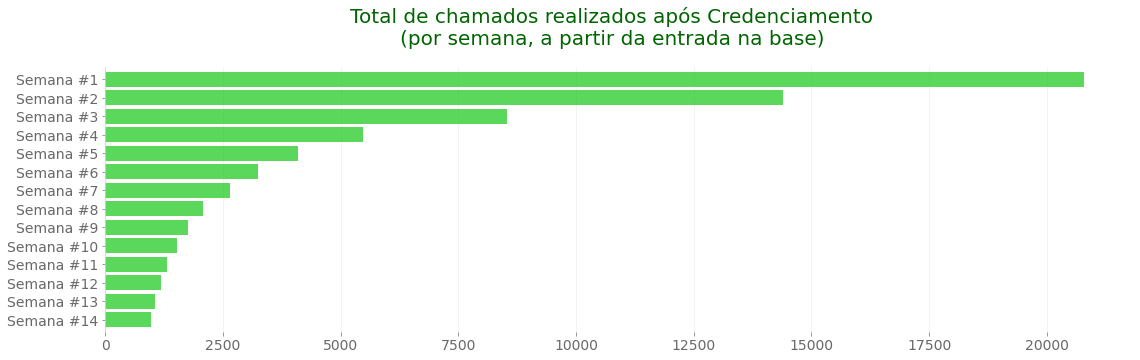

In [35]:
n_call_timewindow(mcases, n_days = 100, plot = True);

In [308]:
# Substituindo valores 'NONE' em max_machine por np.nan

# Criando função que irá substituir os valores NONE
def to_nan(x):
    if x == 'NONE':
        return np.nan
    pass

# Aplicando função à coluna max_machine
mcases['max_machine'] = mcases['max_machine'].apply(to_nan)

In [294]:
# Investigando dados estranhos: chamados efetuados antes da data de credenciamento
# mcases[mcases['date_ref'] < mcases['cred_date']][['account_id', 'cred_date', 'date_ref', 'node_1', 'node_2', 'node_3']]

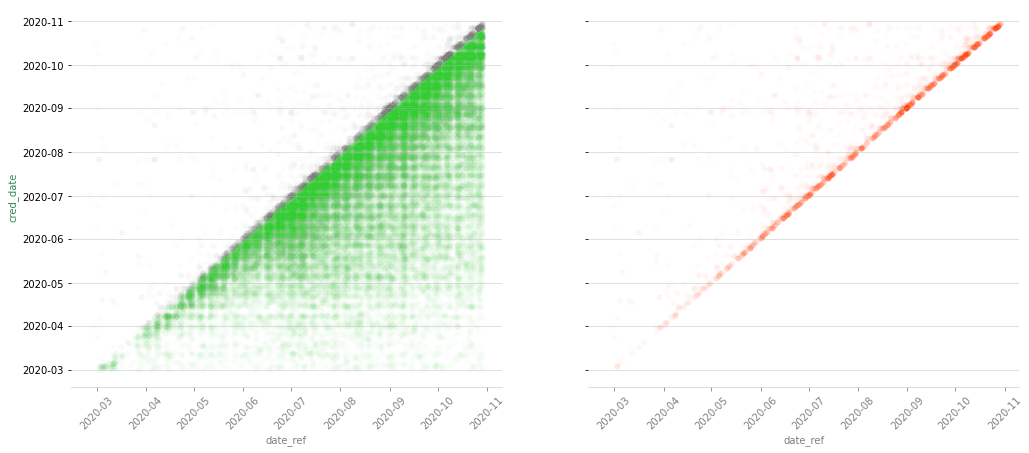

In [295]:
fig, ax = plt.subplots(1, 2, sharey = True, figsize = (17, 7))

# First Plot
ax[0].grid(b = True, axis = 'y', alpha = .5, zorder = -1)
sns.scatterplot('date_ref', 'cred_date', 
                data = mcases[(mcases['cred_date'] >= '2020-03-01') & (mcases['cred_date'] < mcases['date_ref'])], 
                alpha = .02, color = 'limegreen', ax = ax[0])
sns.scatterplot('date_ref', 'cred_date', 
                data = mcases[mcases['cred_date'] > mcases['date_ref']], 
                alpha = .02, color = 'gray', ax = ax[0])

ax[0].spines['bottom'].set_color('lightgray')
ax[0].xaxis.label.set_color('gray')
ax[0].tick_params(axis='x', colors='gray', rotation = 45)
ax[0].yaxis.label.set_color("seagreen")

# Second plot
ax[1].grid(b = True, axis = 'y', alpha = .5, zorder = -1)
sns.scatterplot('date_ref', 'cred_date', 
                data = mcases[(mcases['cred_date'] >= '2020-03-01') & (mcases['cred_date'] < mcases['date_ref'])], 
                alpha = .0002, color = 'gray', hue = 'max_machine', ax = ax[1])
sns.scatterplot('date_ref', 'cred_date', 
                data = mcases[mcases['cred_date'] > mcases['date_ref']], 
                alpha = .02, color = 'orangered', ax = ax[1])

ax[1].spines['bottom'].set_color('lightgray')
ax[1].xaxis.label.set_color('gray')
ax[1].tick_params(axis='x', colors='gray', rotation = 45)
ax[1].yaxis.label.set_color("seagreen")

sns.despine(top = True, left = True)

In [34]:
mcases.head(3)

,account_id,date_ref,waiting_time,missed,pesq_satisfacao,assunto,waiting_timedelta,year_cases,month_cases,day_cases,weekday_cases,weekday_str_cases,node_1,node_2,node_3,calls,cred_date,ship_city,ship_state,max_machine,year_creds,month_creds,day_creds,weekday_creds,weekday_str_creds,interval_cred_call
0,0011L00002ZbpnlQAB,2020-02-23,19,False,Enviado,"['Produto', 'mPOS', 'Dúvidas mpos']",0 days 00:00:19,2020,2,23,6,Dom,Produto,mPOS,Dúvidas mpos,1,2019-10-28,Atibaia,SP,NaN,2019,10,28,0,Seg,118
1,0011L00002dbBg5QAE,2020-02-25,15,False,Enviado,"['Aplicativo', 'Problema', '']",0 days 00:00:15,2020,2,25,1,Ter,Aplicativo,Problema,NaN,1,2020-02-12,Alexânia,GO,NaN,2020,2,12,2,Qua,13
2,0011L00002WdgbcQAB,2020-02-26,15,False,Enviado,"['Aplicativo', 'Dúvidas funcionalidades App', ...",0 days 00:00:15,2020,2,26,2,Qua,Aplicativo,Dúvidas funcionalidades App,Redefinição de senha,1,2019-07-28,Indaiatuba,SP,NaN,2019,7,28,6,Dom,213


In [38]:
# plt.figure(figsize = (15, 15))
# sns.jointplot('date_ref', 'cred_date', hue = 'month', kind = 'hex', data = mcases, alpha = 0.01);

In [39]:
mcases[mcases['node_1'] == 'Produto']['node_3'].value_counts()

Dúvidas                                 5887
Ativação                                2165
Dúvida S920                             1955
Falha de Conexão - não revertido        1853
Dúvida D195                             1697
Pareamento                              1417
Falha de Conexão - revertido             936
Dúvidas pinpad                           838
Problema                                 676
Atendimento acesso                       565
Problema Revertido                       264
Dúvidas mpos                             201
Falha no pareamento                      164
Atualização                              122
Falha de conexão - wifi - revertido      120
Alteração de dados na Acesso              91
Falha de conexão - GPRS - revertido       87
Transferência de Saldo entre cartões      53
Transferência de Saldo para conta         48
Falha na atualização                      21
Problema POS - revertido                  16
Falha na ativação                         11
Name: node

In [40]:
cases_per_state = mcases.groupby('ship_state')[['calls']].sum()
creds_per_state = creds.groupby('ship_state')[['account_id']].nunique()

agg_per_state = cases_per_state.merge(creds_per_state, right_index = True, left_index = True)
(agg_per_state['calls'] / agg_per_state['account_id']).sort_values(ascending = False)

ship_state
TO    2.761062
AC    2.678571
RN    2.610413
SE    2.591362
CE    2.584835
RJ    2.584454
BA    2.554893
GO    2.549713
MT    2.532338
PE    2.521799
PB    2.520548
ES    2.506472
AM    2.466667
MG    2.452963
PR    2.444838
MA    2.442460
DF    2.435312
SC    2.434295
PA    2.424855
AL    2.401662
AP    2.397436
RS    2.372508
SP    2.357311
MS    2.302920
PI    2.279310
RR    2.191489
RO    2.134328
dtype: float64

___
---

## Rascunhos

In [ ]:
# # Criando coluna cred_year_month para a tabela Creds
# creds['cred_year_month'] = creds['year'].astype(str) + '-' + creds['month'].astype(str)

In [ ]:
# mcases['cred_year_month'] = mcases['year_creds'].astype(str) + '-' + mcases['month_creds'].astype(str)

In [ ]:
# creds.groupby(pd.Grouper(key = 'cred_date', freq = 'W')).count()

In [ ]:
# _mcases_agg = mcases.copy()
# idx_to_drop = _mcases_agg[_mcases_agg['cred_date'] < '2020-02-23'].index
# mcases_ready = _mcases_agg.drop(idx_to_drop)

In [ ]:
# mcases[['account_id', 'date_ref', 'cred_date']]

In [ ]:
# # Aggregation functions to be passed to groupby
# aggregation = {
#     'n_creds': ('account_id', pd.Series.nunique),
#     'n_calls': ('date_ref', 'count')
# }

# # Groupby splitting dates in weeks and with specified aggregations
# mcases_agg = mcases_ready.groupby(pd.Grouper(key = 'cred_date', freq = 'W')).agg(**aggregation)
# mcases_idx_list = mcases_agg.index.tolist()

In [ ]:
# mcases_idx_list

In [ ]:
# n_calls_list = []
# for i, _ in enumerate(mcases_idx_list):
#     if i == 0:
#         df = mcases[mcases['cred_date'] <= mcases_idx_list[i]]
#         n_calls_from_cred_this_week = df[(df['date_ref'] >= mcases_idx_list[i]) & (df['date_ref'] < (mcases_idx_list[i + 1]))]['account_id'].nunique()
#         n_calls_list.append(n_calls_from_cred_this_week)
        
#     elif i != len(mcases_idx_list) - 1:
#         df = mcases[mcases['cred_date'] <= mcases_idx_list[i]]
#         n_calls_from_cred_this_week = df[(df['date_ref'] >= mcases_idx_list[i]) & (df['date_ref'] < (mcases_idx_list[i + 1]))]['account_id'].nunique()
#         n_calls_list.append(n_calls_from_cred_this_week)
        
#     else:    
#         df = mcases[mcases['cred_date'] <= mcases_idx_list[i]]
#         n_calls_from_cred_this_week = df[(df['date_ref'] >= mcases_idx_list[i])]['account_id'].nunique()
#         n_calls_list.append(n_calls_from_cred_this_week)

In [ ]:
# mcases_agg['n_calls_from_cred_this_week'] = n_calls_list
# mcases_agg

In [ ]:
# df[(df['date_ref'] >= mcases_idx_list[0]) & (df['date_ref'] < (mcases_idx_list[0 + 1]))]

In [ ]:
# date = mcases_idx_list[0]
# df = mcases[mcases['cred_date'] <= date]
# n_calls_from_cred_this_week = df[(df['date_ref'] >= date) & (df['date_ref'] < (date + np.timedelta64(1, 'D')))]['account_id'].nunique()
# n_calls_list.append(n_calls_from_cred_this_week)
# n_calls_list

In [ ]:
# df = mcases[(mcases['cred_date'] <= '2020-03-01') & (mcases['cred_date'] >= '2020-02-23')]
# df

In [ ]:
# mcases['date_ref'].min()

In [ ]:
# mcases_agg['n_calls_from_cred_this_week'] = None
# mcases_agg['n_calls_from_cred_this_week']
# # test = pd.DataFrame(mcases_agg.iloc[1]).T
# # test['teste'] = 0

# # test

In [ ]:
# _cred_sup = pd.DataFrame(creds.groupby('cred_year_month').count()['account_id'])
# _cred_sup

In [ ]:
# _cases_sup = pd.DataFrame(mcases.groupby('cred_year_month').count()['account_id']).rename(columns = {'account_id': 'n_calls'})
# _cases_sup

In [ ]:
# cred_calls = _cred_sup.merge(_cases_sup, how = 'outer', left_index = True, right_index = True)
# cred_calls

In [ ]:
# call_breakdown = mcases[['account_id', 'date_ref']].groupby('account_id').agg({'date_ref': ['min', 'max'], 
#                                                                                'account_id': 'count'})

# call_breakdown = call_breakdown.rename(columns = {'date_ref': 'calls', 'account_id': 'n_total_calls'})
# call_breakdown['timespan_first_last_call_days'] = call_breakdown['calls', 'max'] - call_breakdown['calls', 'min'] + np.timedelta64(1, 'D')
# call_breakdown['timespan_first_last_call_months'] = call_breakdown['timespan_first_last_call_days'].dt.days
# call_breakdown['call_per_month'] = call_breakdown['n_total_calls', 'count'] / call_breakdown['timespan_first_last_call_months']

# call_breakdown

In [ ]:
# call_breakdown.info()

In [ ]:
# call_breakdown['timespan_first_last_call_months'].describe()

In [ ]:
# sns.boxplot(call_breakdown[call_breakdown['timespan_first_last_call_months'] < 100]['timespan_first_last_call_months'])

In [ ]:
# sns.distplot(call_breakdown['timespan_first_last_call_months']);

In [ ]:
# def get_month_spam(df):
#     date_1 = df['calls', 'max']
#     date_2 = df['calls', 'min']
#     difference = relativedelta.relativedelta(date_2, date_1)
#     months = difference.months
#     return months

In [ ]:
# # Número de clientes que ligaram apenas uma ves
# print(len(call_breakdown[call_breakdown['n_total_calls', 'count'] == 1]))

# # Número de clientes que ligaram mais de uma vez
# print(len(call_breakdown[call_breakdown['n_total_calls', 'count'] > 1]))

In [ ]:
# call_breakdown['n_total_calls', 'count'].mean()
# call_breakdown['n_total_calls', 'count'].median()
# call_breakdown['n_total_calls', 'count'].std()

# call_breakdown['n_total_calls', 'count'].value_counts() 
# #  * call_breakdown['n_total_calls', 'count'].value_counts().index )

In [ ]:
# # Número de ligações - clientes que ligaram apenas uma vez
# print(call_breakdown['n_total_calls', 'count'].value_counts()[:1].sum())

# # Número de ligações - clientes que ligam mais de uma vez
# print(call_breakdown[call_breakdown['n_total_calls', 'count'] > 1]['n_total_calls', 'count'].sum())

In [ ]:
# mcases['interval_7'] = (mcases['interval_cred_call'] <= 7).astype(int)
# mcases['interval_14'] = ((mcases['interval_cred_call'] > 7) & (mcases['interval_cred_call'] <= 14)).astype(int)
# mcases['interval_21'] = ((mcases['interval_cred_call'] > 14) & (mcases['interval_cred_call'] <= 21)).astype(int)
# mcases['interval_28'] = ((mcases['interval_cred_call'] > 21) & (mcases['interval_cred_call'] <= 28)).astype(int)
# mcases['interval_35'] = ((mcases['interval_cred_call'] > 28) & (mcases['interval_cred_call'] <= 35)).astype(int)

# mcases_intervals = mcases.groupby('account_id')[['interval_7', 'interval_14', 'interval_21', 'interval_28', 'interval_morethan_28']].sum()

In [ ]:
# mcases_intervals['interval_7'].sum(), \
# mcases_intervals['interval_14'].sum(), \
# mcases_intervals['interval_21'].sum(), \
# mcases_intervals['interval_28'].sum(), \
# mcases_intervals['interval_morethan_28'].sum()

In [ ]:


# sum_intervals = sum((mcases_intervals['interval_7'].sum(), \
# mcases_intervals['interval_14'].sum(), \
# mcases_intervals['interval_21'].sum(), \
# mcases_intervals['interval_28'].sum(), \
# mcases_intervals['interval_morethan_28'].sum())[0:4])

# sum_intervals / len(mcases) 

In [ ]:
# sns.distplot(mcases['cred_date'])
# sns.distplot(mcases['date_ref'])

In [ ]:
# plt.figure(figsize = (7, 7))
# ax = plt.gca()

# plt.hexbin(pl.date2num(mcases['date_ref']), pl.date2num(mcases['cred_date']), 
#            gridsize = 100,
#            alpha = .7, 
#            cmap = 'ocean_r',
#            bins = 'log')
# ax.legend()
# ax.yaxis_date()
# ax.xaxis_date()
# plt.xticks(rotation = 45);

In [ ]:
# mcases_first_call = mcases.groupby('account_id').agg({'date_ref': 'min', 'cred_date': 'min'})
# mcases_first_call['days_until_first_call'] = (mcases_first_call['date_ref'] - mcases_first_call['cred_date']).dt.days
# (mcases_first_call['days_until_first_call']).median()

# sns.distplot(mcases_first_call[mcases_first_call['days_until_first_call'] >= 0]['date_ref'])

In [ ]:
# cred_cases_shifted_3days = cred_cases[['n_creds']].merge(cred_cases.iloc[:, 1:].shift(10), 
#                                                          how = 'inner', 
#                                                          left_index = True,
#                                                          right_index = True)

# cred_cases_shifted_3days = cred_cases_shifted_3days.dropna(axis = 0, how = 'any')
# cred_cases_shifted_3days = cred_cases_shifted_3days.iloc[:-10, :] # Dropando últimas três linhas para fair analysis

In [ ]:
# cred_cases_shifted_3days_before = cred_cases_shifted_3days[cred_cases_shifted_3days.index < shift_date]
# cred_cases_shifted_3days_after = cred_cases_shifted_3days[cred_cases_shifted_3days.index >= shift_date]

In [ ]:
# cred_cases_shifted_3days_before.shape, cred_cases_shifted_3days_after.shape

In [ ]:
# cred_cases_shifted_3days_before

In [ ]:
# plt.figure(figsize = (10, 6))
# sns.distplot(cred_cases_shifted_3days_before['calls_per_total_creds'], color = 'red') # ANTES DA IMPLEMENTAÇÃO
# sns.distplot(cred_cases_shifted_3days_after['calls_per_total_creds'], color = 'green'); # DEPOIS DA IMPLEMENTAÇÃO